# sGDML PES Application
- http://docs.sgdml.org/applications.html#md-simulations

In [1]:
from sgdml.intf.ase_calc import SGDMLCalculator
from ase.io import read, write
from ase.optimize import QuasiNewton
from ase.md.velocitydistribution import (MaxwellBoltzmannDistribution, Stationary, ZeroRotation)
from ase.md.verlet import VelocityVerlet
from ase.vibrations import Vibrations
from ase import units

In [2]:
#model_path = 'ethanol.npz'
model_path = 'ethanolQChem-QChem-train1700-sym6.npz'
calc = SGDMLCalculator(model_path)

mol = read('ethanol.xyz')
mol.set_calculator(calc)

# do a quick geometry relaxation
qn = QuasiNewton(mol)
qn.run(1e-4, 100)

# run the vibration calculations
vib = Vibrations(mol)
vib.run()

vib.summary() # print a summary of the vibrational frequencies
vib.write_jmol() # write file for viewing of the modes with jmol

vib.clean() # remove pickle-files

[WARN] Please remember to specify the proper conversion factors, if your model does not use
       'kcal/mol' and 'Ang' as units.


                Step[ FC]     Time          Energy          fmax
BFGSLineSearch:    0[  0] 10:44:51    -4216.552727        2.2341
BFGSLineSearch:    1[  2] 10:44:51    -4216.689411        1.1833
BFGSLineSearch:    2[  4] 10:44:51    -4216.779834        0.4816
BFGSLineSearch:    3[  6] 10:44:51    -4216.789395        0.2866
BFGSLineSearch:    4[  8] 10:44:51    -4216.799551        0.4012
BFGSLineSearch:    5[ 10] 10:44:51    -4216.807241        0.1624
BFGSLineSearch:    6[ 11] 10:44:51    -4216.814702        0.2195
BFGSLineSearch:    7[ 13] 10:44:51    -4216.821181        0.1875
BFGSLineSearch:    8[ 15] 10:44:51    -4216.834024        0.3819
BFGSLineSearch:    9[ 17] 10:44:51    -4216.839460        0.5230
BFGSLineSearch:   10[ 18] 10:44:51    -4216.854191        0.2808
BFGSLineSearch:   11[ 20] 10:44:51    -4216.861088        0.2863
BFGSLineSearch:   12[ 22] 10:44:52    -4216.869135        0.5143
BFGSLineSearch:   13[ 23] 10:44:52    -4216.877995        0.2969
BFGSLineSearch:   14[ 24]

55

From [sGDML tutorial](http://docs.sgdml.org/applications.html)

![ethanol frequencies](ethanol_freq.png)

## Molecular Dynamics

In [5]:
# set the momenta corresponding to T=300K
MaxwellBoltzmannDistribution(mol, 300 * units.kB)
Stationary(mol) # zero linear momentum
ZeroRotation(mol) # zero angular momentum

# run MD with constant energy using the velocity verlet algorithm
dyn = VelocityVerlet(mol, 0.2 * units.fs, trajectory='md.traj')  # 0.2 fs time step.

def printenergy(a=mol):
        # function to print the potential, kinetic and total energy
        epot = a.get_potential_energy() / len(a)
        ekin = a.get_kinetic_energy() / len(a)
        print(' Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
                'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))
dyn.attach(printenergy, interval=10)
# now run the dynamics
printenergy(mol)
dyn.run(1000)
# Now save to extended xyz file
write('ethanol_MD.xyz', read('md.traj'))

 Energy per atom: Epot = -468.544eV  Ekin = 0.026eV (T=201K)  Etot = -468.518eV
 Energy per atom: Epot = -468.544eV  Ekin = 0.026eV (T=201K)  Etot = -468.518eV
 Energy per atom: Epot = -468.537eV  Ekin = 0.019eV (T=151K)  Etot = -468.518eV
 Energy per atom: Epot = -468.530eV  Ekin = 0.012eV (T= 95K)  Etot = -468.518eV
 Energy per atom: Epot = -468.528eV  Ekin = 0.010eV (T= 78K)  Etot = -468.518eV
 Energy per atom: Epot = -468.529eV  Ekin = 0.012eV (T= 90K)  Etot = -468.518eV
 Energy per atom: Epot = -468.534eV  Ekin = 0.016eV (T=124K)  Etot = -468.518eV
 Energy per atom: Epot = -468.531eV  Ekin = 0.013eV (T=102K)  Etot = -468.518eV
 Energy per atom: Epot = -468.529eV  Ekin = 0.011eV (T= 84K)  Etot = -468.518eV
 Energy per atom: Epot = -468.529eV  Ekin = 0.012eV (T= 90K)  Etot = -468.518eV
 Energy per atom: Epot = -468.533eV  Ekin = 0.015eV (T=115K)  Etot = -468.518eV
 Energy per atom: Epot = -468.533eV  Ekin = 0.016eV (T=121K)  Etot = -468.518eV
 Energy per atom: Epot = -468.530eV  Eki

In [6]:
import numpy as np
from scipy.fftpack import fft, fftfreq
from ase.io.trajectory import Trajectory

def pdos(V, dt):
    """
    Calculate the phonon density of states from a trajectory of
    velocities (power spectrum of the velocity auto-correlation
    function).

    Parameters
    ----------
    V : :obj:`numpy.ndarray`
        (dims N x T) velocities of N degrees of freedom for
        trajetory of length T
    dt : float
        time between steps in trajectory (fs)

    Returns
    -------
    freq : :obj:`numpy.ndarray`
        (dims T) Frequencies (cm^-1)
    pdos : :obj:`numpy.ndarray`
        (dims T) Density of states (a.u.)
    """

    n_steps = V.shape[1]

    # mean velocity auto-correlation for all degrees of freedom
    vac2 = [np.correlate(v, v, 'full') for v in V]
    vac2 /= np.linalg.norm(vac2, axis=1)[:, None]
    vac2 = np.mean(vac2, axis=0)

    # power spectrum (phonon density of states)
    pdos = np.abs(fft(vac2))**2
    pdos /= np.linalg.norm(pdos) / 2 # spectrum is symmetric

    freq = fftfreq(2*n_steps-1, dt) * 33356.4095198152 # Frequency in cm^-1

    return freq[:n_steps], pdos[:n_steps]

# load MD trajectory
traj = Trajectory('md.traj')

# read velocities
V = np.array([atoms.get_velocities() for atoms in traj])

# time step that was used for the MD simulation
dt = 0.2

n_steps = V.shape[0]
V = V.reshape(n_steps, -1).T
freq, pdos = pdos(V, dt)

# smoothing of the spectrum
# (removes numerical artifacts due to finite time trunction of the FFT)
from scipy.ndimage import  gaussian_filter1d as gaussian
pdos = gaussian(pdos, sigma=50)

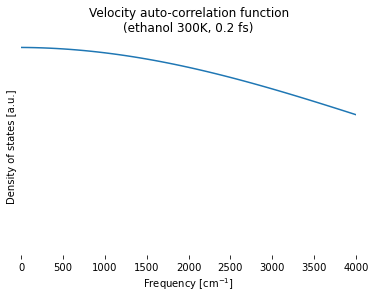

In [7]:
import matplotlib.pyplot as plt

plt.plot(freq, pdos)
plt.yticks([])
plt.xlim(0, 4000)

plt.box(on=None)

plt.xlabel('Frequency [cm$^{-1}$]')
plt.ylabel('Density of states [a.u.]')
plt.title('Velocity auto-correlation function\n(ethanol 300K, 0.2 fs)')
plt.savefig('vaf.png')
plt.show()